--2024-12-13 03:37:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 173.194.210.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   103MB/s    in 0.6s    

2024-12-13 03:37:29 (103 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1966s 31s/step - accuracy: 0.6194 - loss: 1.7409 - val_accuracy: 0.8890 - val_loss: 0.2849
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1977s 31s/step - accuracy: 0.8137 - loss: 0.4006 - val_accuracy: 0.9060 - val_loss: 0.2415
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1926s 31s/step - accuracy: 0.8278 - loss: 0.3568 - val_accuracy: 0.9120 - val_loss: 0.2311
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1908s 30s/step - accuracy: 0.8496 - loss: 0.3434 - val_accuracy: 0.8800 - val_loss: 0.2594
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1931s 30s/step - accuracy: 0.8441 - loss: 0.3550 - val_accuracy: 0.9220 - val_loss: 0.2039
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1893s 30s/step - accuracy: 0.8476 - loss: 0.3203 - val_accuracy: 0.9210 - val_loss: 0.1969
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1965s 31s/step - accuracy: 0.8611 - loss: 0.3283 - val_accuracy: 0.9190 - val_loss: 0.2062
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1982s 31s/step - accuracy: 0.8475 - loss: 0.3264 - val_accuracy: 0.915

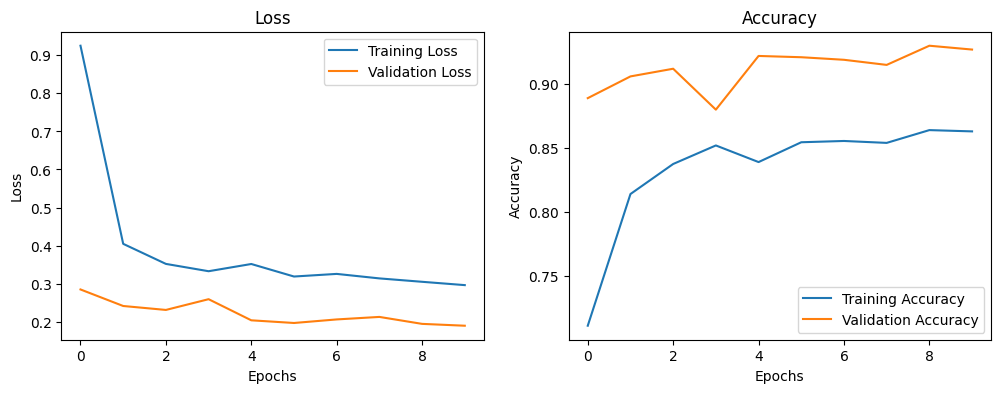

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# URL atualizado para o dataset
new_data_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset_path = "cats_and_dogs_filtered.zip"

# Download e extração do dataset
if not os.path.exists(dataset_path):
    !wget -O {dataset_path} {new_data_url}

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("cats_and_dogs")

base_dir = "cats_and_dogs/cats_and_dogs_filtered"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Pré-processamento dos dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Carregar a arquitetura VGG16 pré-treinada
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Construir o modelo
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compilação do modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Treinamento do modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Avaliação do modelo
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Visualização das métricas
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
